In [172]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [173]:
import sys
import os
from IPython.lib.display import FileLink

In [177]:
LOCAL_FAST_AI = '/Users/krishnakalyan3/Educational/FastAI/fastai/'
AWS_FAST_AI = '/home/ubuntu/fastai'
sys.path.append(AWS_FAST_AI)
from fastai.imports import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [178]:
PATH = '/home/ubuntu/kaggle/dogbreeds/'

In [179]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

# Step 1 : Find the size of Images

In [180]:
files = !ls {PATH}train | head 
files

['000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '002211c81b498ef88e1b40b9abf84e1d.jpg',
 '00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '002a283a315af96eaea0e28e7163b21b.jpg',
 '003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '0042188c895a2f14ef64a918ed9c7b64.jpg']

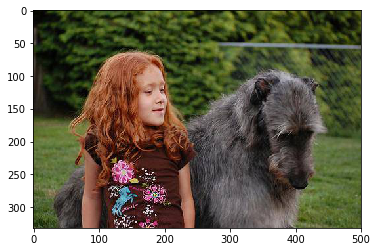

In [181]:
img = plt.imread(f'{PATH}train/{files[9]}')
plt.imshow(img);

In [182]:
img.shape

(332, 500, 3)

In [183]:
# (227, 231, 3)
# (500, 474, 3)
# (332, 500, 3)
arch = resnext101_64
sz = 550
bs = 64
tfms = tfms_from_model(arch, bs, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=label_csv,test_name ='test',
                                    bs=bs, tfms=tfms, val_idxs=val_idxs, suffix='.jpg')

In [184]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz =  list(zip(*size_d.values())) 
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

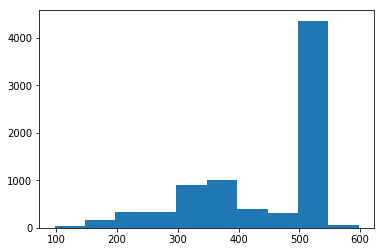

In [185]:
plt.hist(row_sz[row_sz < 600]);

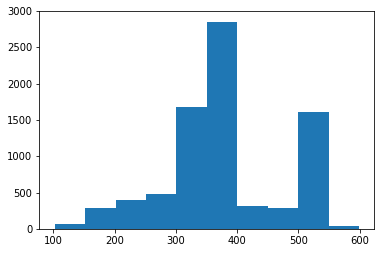

In [186]:
plt.hist(col_sz[col_sz < 600]);

# Step 2 : Simple Training

In [197]:
arch = resnext101_64
sz = 229
bs = 64
tfms = tfms_from_model(arch, bs, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=label_csv,test_name ='test',
                                    bs=bs, tfms=tfms, val_idxs=val_idxs, suffix='.jpg')

In [198]:
len(data.classes)

120

In [199]:
learn = ConvLearner.pretrained(arch, data=data, precompute=True)

In [200]:
lrf = learn.lr_find()

A Jupyter Widget

 91%|█████████▏| 117/128 [00:02<00:00, 46.47it/s, loss=27]  


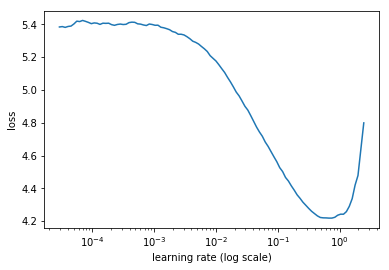

In [201]:
learn.sched.plot()

In [202]:
learn.fit(1e-1, 3)

A Jupyter Widget

[ 0.       3.00233  2.47916  0.37685]                       
[ 1.       2.39135  2.36855  0.40133]                       
[ 2.       2.11016  2.38292  0.39333]                       



# Step 3: Train Last Layer

In [ ]:
learn.precompute=False
learn.fit(1e-1, 3, cycle_len=1)

A Jupyter Widget

[ 0.       2.196    2.23508  0.42526]                       
[ 1.       2.13141  2.22115  0.4278 ]                       
 34%|███▎      | 43/128 [00:30<00:59,  1.42it/s, loss=2.09]

In [ ]:
learn.sched.plot_lr()

# Step 4 : Unfreez

In [ ]:
learn.unfreeze()
lr=np.array([1e-3,1e-2,1e-1])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_lr()

# Step 5 : Submit to Kaggle

In [164]:
log_preds,y = learn.TTA()
y_pred = np.exp(log_preds)
preds = np.argmax(log_preds, axis=1)


100%|██████████| 4/4 [00:19<00:00,  4.83s/it]
                                             

In [165]:
from sklearn.metrics import accuracy_score
accuracy_score(y, preds)

0.50636007827788654

In [166]:
log_preds_test,y_test = learn.TTA(is_test=True)
y_pred = np.exp(log_preds_test)
preds = np.argmax(log_preds_test, axis=1)


100%|██████████| 4/4 [02:01<00:00, 30.28s/it]
                                             

In [167]:
accuracy_score(y_test, preds)

0.006951820025103795

In [168]:
columns = pd.read_csv(PATH + 'sample_submission.csv', index_col='id').columns
test = learn.TTA(is_test=True)[0]
test = pd.DataFrame(np.exp(test))
test.columns = columns
test.index = [i.split('.jpg')[0].split('/')[-1] for i in data.test_dl.dataset.fnames]
test.index.name ='id'


100%|██████████| 4/4 [02:35<00:00, 38.81s/it]
                                             

In [169]:
test.to_csv('/home/ubuntu/FastAI_Practice/scripts/output/submission_101.csv', index=True, encoding='utf-8')